<a href="https://colab.research.google.com/github/salmanromeo/1D_Pitching_Moment/blob/main/Multi_Fidelity_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Standard GP**

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

In [ ]:
!pip install gpax

In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

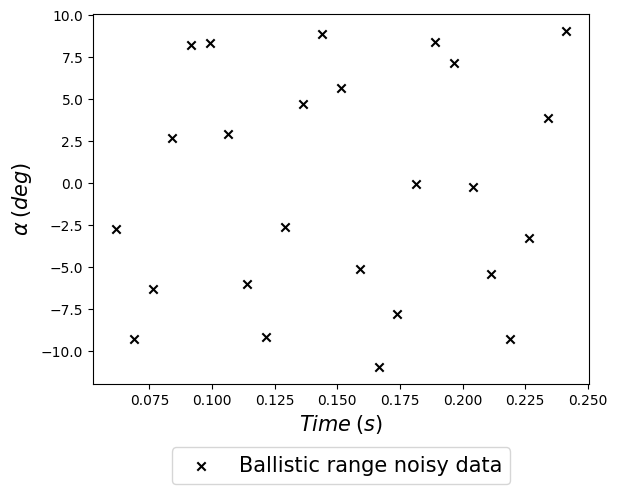

In [ ]:
np.random.seed(42)

# Load data (M=1.44; A_0=1 deg)
t_true = np.load('/content/sample_data/tdata_10.npy')
y_true = np.load('/content/sample_data/rdata_10.npy')

X = t_true[::1500][2:27]
y_d = y_true[::1500][2:27]

# Add noise to y
noise_level = 1  # Adjust the noise level as needed
y = y_d + np.random.normal(0., noise_level, len(y_d))

# Plot the original and noisy data
plt.figure(dpi=100)
#plt.plot(t_true[:800][::4], y_true[:800][::4], label='FFCFD data', c='green')
plt.scatter(X, y, marker='x', label='Ballistic range noisy data', c='black')
plt.xlabel(r'$Time\:(s)$',fontsize=15)
plt.ylabel(r'$\alpha\:(deg)$', labelpad=5,fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.3))
plt.show()

In [ ]:
# Get random number generator keys for training and prediction
rng_key, rng_key_predict = gpax.utils.get_keys()

# Normalize X to be in the range [0, 1] for better GP regression performance
X_normalized = (X - X.min()) / (X.max() - X.min())

# Initialize model
gp_model = gpax.ExactGP(1, kernel='RBF')

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, X_normalized, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:21<00:00, 188.11it/s, 7 steps of size 7.39e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.61      2.00      0.99      0.06      3.52   1530.23      1.00
    k_scale      1.26      1.51      0.83      0.03      2.70   1428.14      1.00
      noise     37.51      9.63     36.08     21.87     51.02   1878.68      1.00



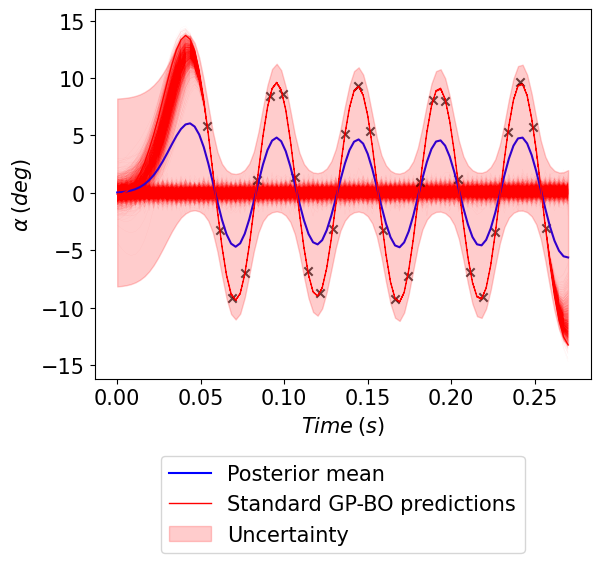

In [ ]:
# Prepare test inputs
X_test = np.linspace(0, 0.3, 100)
X_test_normalized = (X_test - X.min()) / (X.max() - X.min())

# Get the GP prediction. Here n stands for the number of samples from each MVNormal distribution
# (the total number of MVNormal distributions is equal to the number of HMC samples)
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test_normalized, n=200)

# Plot the results
_, ax = plt.subplots(dpi=100)
ax.scatter(X, y, marker='x', c='black', alpha=0.7)
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='blue', label='Posterior mean')
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='red', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='red', alpha=1, label="Standard GP-BO predictions")
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.2, label="Uncertainty")
plt.xlabel(r'$Time\:(s)$',fontsize=15)
plt.ylabel(r'$\alpha\:(deg)$', labelpad=5,fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.5))
plt.show()

**Structured GP**

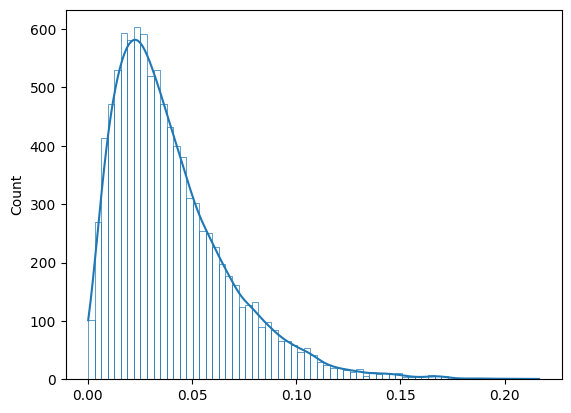

In [ ]:
import numpyro

d = numpyro.distributions.Gamma(2, 50)

gpax.utils.dviz(d, samples=10000)

In [ ]:
def get_kernel_prior(p=None):

    def kernel_prior():
        # Sample kernel length and output scales
        length = numpyro.sample("k_length", numpyro.distributions.Gamma(2, 5))
        scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
        # Sample period or set it to a constant value
        if p:
            period = numpyro.deterministic("period", p)
        else:
            period = numpyro.sample("period", numpyro.distributions.Gamma(2, 5))
        # Hyperparameters are returned as dictionary
        return {"k_length": length, "k_scale": scale, "period": period}

    return kernel_prior

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 4000/4000 [01:15<00:00, 53.02it/s, 63 steps of size 1.13e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.23      0.10      0.22      0.09      0.37    227.97      1.00
   k_scale     68.39     34.24     61.08     24.40    107.25    769.47      1.00
     noise      0.07      0.08      0.05      0.00      0.16    194.42      1.02
    period      0.47      0.22      0.42      0.19      0.75    437.34      1.00



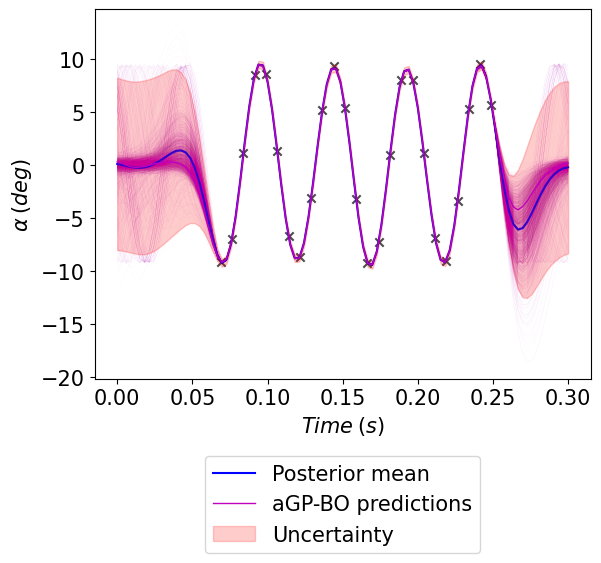

In [ ]:
for p in [None]:
    # Get a kernel prior function and initialize the model
    k_prior = get_kernel_prior(p)
    gp_model = gpax.ExactGP(1, kernel='Periodic', kernel_prior=k_prior)
    # Run HMC to obtain posterior samples
    gp_model.fit(rng_key, X, y, num_chains=1)
    # Get GP prediction
    X_test = np.linspace(0, 0.3, 100)
    X_test_normalized = (X_test - X.min()) / (X.max() - X.min())
    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=400)

    # Plot results
    _, ax = plt.subplots(dpi=100)
    ax.scatter(X, y, marker='x', c='black', alpha=0.7)
    ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Posterior mean')
    for y1 in y_sampled:
        ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='m', alpha=.1)
    l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='m', alpha=1, label="aGP-BO predictions")
    ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.2, label="Uncertainty")
    plt.xlabel(r'$Time\:(s)$',fontsize=15)
    plt.ylabel(r'$\alpha\:(deg)$', labelpad=5,fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.5))
    plt.show()

**Multi Fidelity GP**

In [ ]:
import os

if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 100
    NUM_SAMPLES = 100
    SMOKE = True
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000
    SMOKE = False

# Add fidelity indices
X_g = np.vstack(
    (np.column_stack((t_true[:50000][::250], np.zeros_like(t_true[:50000][::250]))),  # add indices associated with the fidelity
     np.column_stack((X, np.ones_like(X))))   # add indices associated with the fidelity
)

# We will pass target values to GP as a single array
y_g = np.concatenate([y_true[:50000][::250], y]).squeeze()

key1, key2 = gpax.utils.get_keys(1)

model = gpax.MultiTaskGP(
    input_dim=1, data_kernel= 'Matern',  # standard GP parameters
    shared_input_space=False,  # different fidelities have differnet number of observations
    num_latents=2,  rank=2,  # number of latent functions Q and rank of matrix W
)

model.fit(
    key1,
    X_g,
    y_g,
    num_warmup=500 if not SMOKE else NUM_WARMUP // 10,
    num_samples=500 if not SMOKE else NUM_SAMPLES // 10
)

sample: 100%|██████████| 1000/1000 [08:26<00:00,  1.98it/s, 127 steps of size 2.81e-02. acc. prob=0.95]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]     -0.30      4.75     -0.74     -6.75      6.71    129.17      1.00
     W[0,0,1]     -0.67      4.86     -1.37     -7.15      6.47    112.99      1.00
     W[0,1,0]     -0.28      4.77     -0.88     -6.86      6.76    130.73      1.00
     W[0,1,1]     -0.67      4.95     -1.05     -7.37      6.52    110.42      1.00
     W[1,0,0]      0.06      0.96      0.01     -1.50      1.60    578.68      1.00
     W[1,0,1]     -0.02      0.95     -0.07     -1.67      1.43    575.49      1.00
     W[1,1,0]      0.16      6.95      0.34    -11.23     11.95    452.06      1.00
     W[1,1,1]      0.43      6.27      0.18    -10.67     10.64    489.00      1.00
k_length[0,0]      0.03      0.00      0.03      0.03      0.03    454.78      1.00
k_length[1,0]      1.87      2.41      1.25      0.13      3.66    347.36      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

In [ ]:
# Create a set of inputs for the task/fidelity 2
X_test2 = np.column_stack((t_true[:50000][::250], np.ones_like(t_true[:50000][::250])))

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

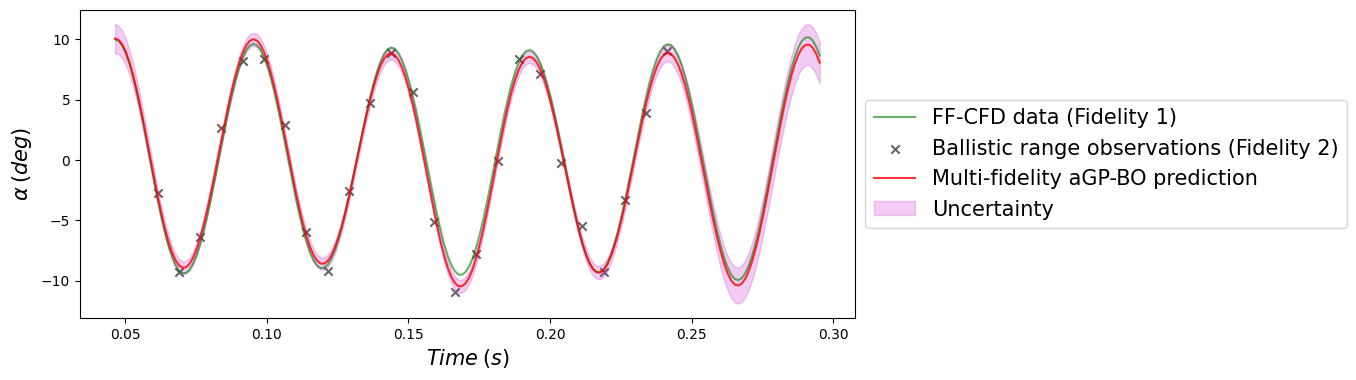

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(t_true[:50000][::250], y_true[:50000][::250], c='green', label='FF-CFD data (Fidelity 1)', alpha=0.6)
plt.scatter(X, y, label='Ballistic range observations (Fidelity 2)', marker='x', c='black', alpha=0.6)
plt.plot(t_true[:50000][::250], y_mean2, c='red',label="Multi-fidelity aGP-BO prediction", alpha=0.8)
plt.fill_between(t_true[:50000][::250],
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.2, color='m', label="Uncertainty")
plt.xlabel(r'$Time\:(s)$',fontsize=15)
plt.ylabel(r'$\alpha\:(deg)$', labelpad=5,fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(loc='center left', fontsize=15, bbox_to_anchor=(1, 0.5))
plt.show()